In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import zscore
!pip install mlflow
!pip install mlflow==2.12.1 pyngrok==7.0.0
import mlflow
import mlflow.xgboost
from mlflow.tracking import MlflowClient
import warnings
warnings.filterwarnings('ignore')

In [29]:
df=pd.read_csv('cleaned_dataset2.csv')
df.head()

,Calculated_Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue,Season,Profit_Margin
0,2011-01-01,1,January,2011,23,Youth (<25),M,Australia,Victoria,Bikes,Mountain Bikes,"Mountain-200 Black, 46",1,1252,2295,561,1252,1813,Winter,30.943188
1,2011-01-01,1,January,2011,33,Young Adults (25-34),F,France,Yveline,Bikes,Road Bikes,"Road-150 Red, 48",2,2171,3578,1097,4342,5439,Winter,20.169149
2,2011-01-01,1,January,2011,17,Youth (<25),M,Canada,British Columbia,Bikes,Road Bikes,"Road-250 Red, 44",1,1519,2443,900,1519,2419,Winter,37.205457
3,2011-01-01,1,January,2011,42,Adults (35-64),M,United States,California,Bikes,Road Bikes,"Road-750 Black, 44",1,344,540,185,344,529,Winter,34.971645
4,2011-01-01,1,January,2011,39,Adults (35-64),M,United States,Washington,Bikes,Road Bikes,"Road-550-W Yellow, 38",3,713,1120,482,2139,2621,Winter,18.389928


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112036 entries, 0 to 112035
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Calculated_Date   112036 non-null  object 
 1   Day               112036 non-null  int64  
 2   Month             112036 non-null  object 
 3   Year              112036 non-null  int64  
 4   Customer_Age      112036 non-null  int64  
 5   Age_Group         112036 non-null  object 
 6   Customer_Gender   112036 non-null  object 
 7   Country           112036 non-null  object 
 8   State             112036 non-null  object 
 9   Product_Category  112036 non-null  object 
 10  Sub_Category      112036 non-null  object 
 11  Product           112036 non-null  object 
 12  Order_Quantity    112036 non-null  int64  
 13  Unit_Cost         112036 non-null  int64  
 14  Unit_Price        112036 non-null  int64  
 15  Profit            112036 non-null  int64  
 16  Cost              11

In [31]:
df.describe()

,Day,Year,Customer_Age,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue,Profit_Margin
count,112036.000000,112036.000000,112036.000000,112036.000000,112036.000000,112036.000000,112036.000000,112036.000000,112036.000000,112036.000000
mean,15.665607,2014.400925,35.919508,11.904254,267.819603,453.850628,286.035194,471.103333,757.138527,47.212544
std,8.781485,1.273327,11.016543,9.564877,550.218722,922.751848,454.852634,886.971635,1312.061623,16.385344
min,1.000000,2011.000000,17.000000,1.000000,1.000000,2.000000,-30.000000,1.000000,2.000000,-3.703704
25%,8.000000,2013.000000,28.000000,2.000000,2.000000,5.000000,29.000000,28.000000,64.000000,35.707845
50%,16.000000,2014.000000,35.000000,10.000000,9.000000,25.000000,103.000000,112.000000,226.000000,52.631579
75%,23.000000,2016.000000,43.000000,20.000000,42.000000,70.000000,360.000000,442.000000,806.000000,59.677419
max,31.000000,2016.000000,87.000000,32.000000,2171.000000,3578.000000,15096.000000,42978.000000,58074.000000,75.000000


In [32]:
df.isnull().sum()

,0
Calculated_Date,0
Day,0
Month,0
Year,0
Customer_Age,0
Age_Group,0
Customer_Gender,0
Country,0
State,0
Product_Category,0


In [33]:
corr = df.select_dtypes(include=[np.number]).corr()
corr

,Day,Year,Customer_Age,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue,Profit_Margin
Day,1.000000,-0.007435,-0.015186,-0.002845,0.003520,0.003578,0.004714,0.003493,0.003995,0.000453
Year,-0.007435,1.000000,0.040879,0.124091,-0.217431,-0.213538,-0.181349,-0.215449,-0.208514,0.127608
Customer_Age,-0.015186,0.040879,1.000000,0.027376,-0.021401,-0.020301,0.004388,-0.016012,-0.009303,0.030021
Order_Quantity,-0.002845,0.124091,0.027376,1.000000,-0.516289,-0.516387,-0.238770,-0.340386,-0.312880,0.289783
Unit_Cost,0.003520,-0.217431,-0.021401,-0.516289,1.000000,0.997891,0.740623,0.829557,0.817544,-0.425559
Unit_Price,0.003578,-0.213538,-0.020301,-0.516387,0.997891,1.000000,0.749450,0.825965,0.818176,-0.413173
Profit,0.004714,-0.181349,0.004388,-0.238770,0.740623,0.749450,1.000000,0.902109,0.956508,-0.173899
Cost,0.003493,-0.215449,-0.016012,-0.340386,0.829557,0.825965,0.902109,1.000000,0.988748,-0.402311
Revenue,0.003995,-0.208514,-0.009303,-0.312880,0.817544,0.818176,0.956508,0.988748,1.000000,-0.332254
Profit_Margin,0.000453,0.127608,0.030021,0.289783,-0.425559,-0.413173,-0.173899,-0.402311,-0.332254,1.000000


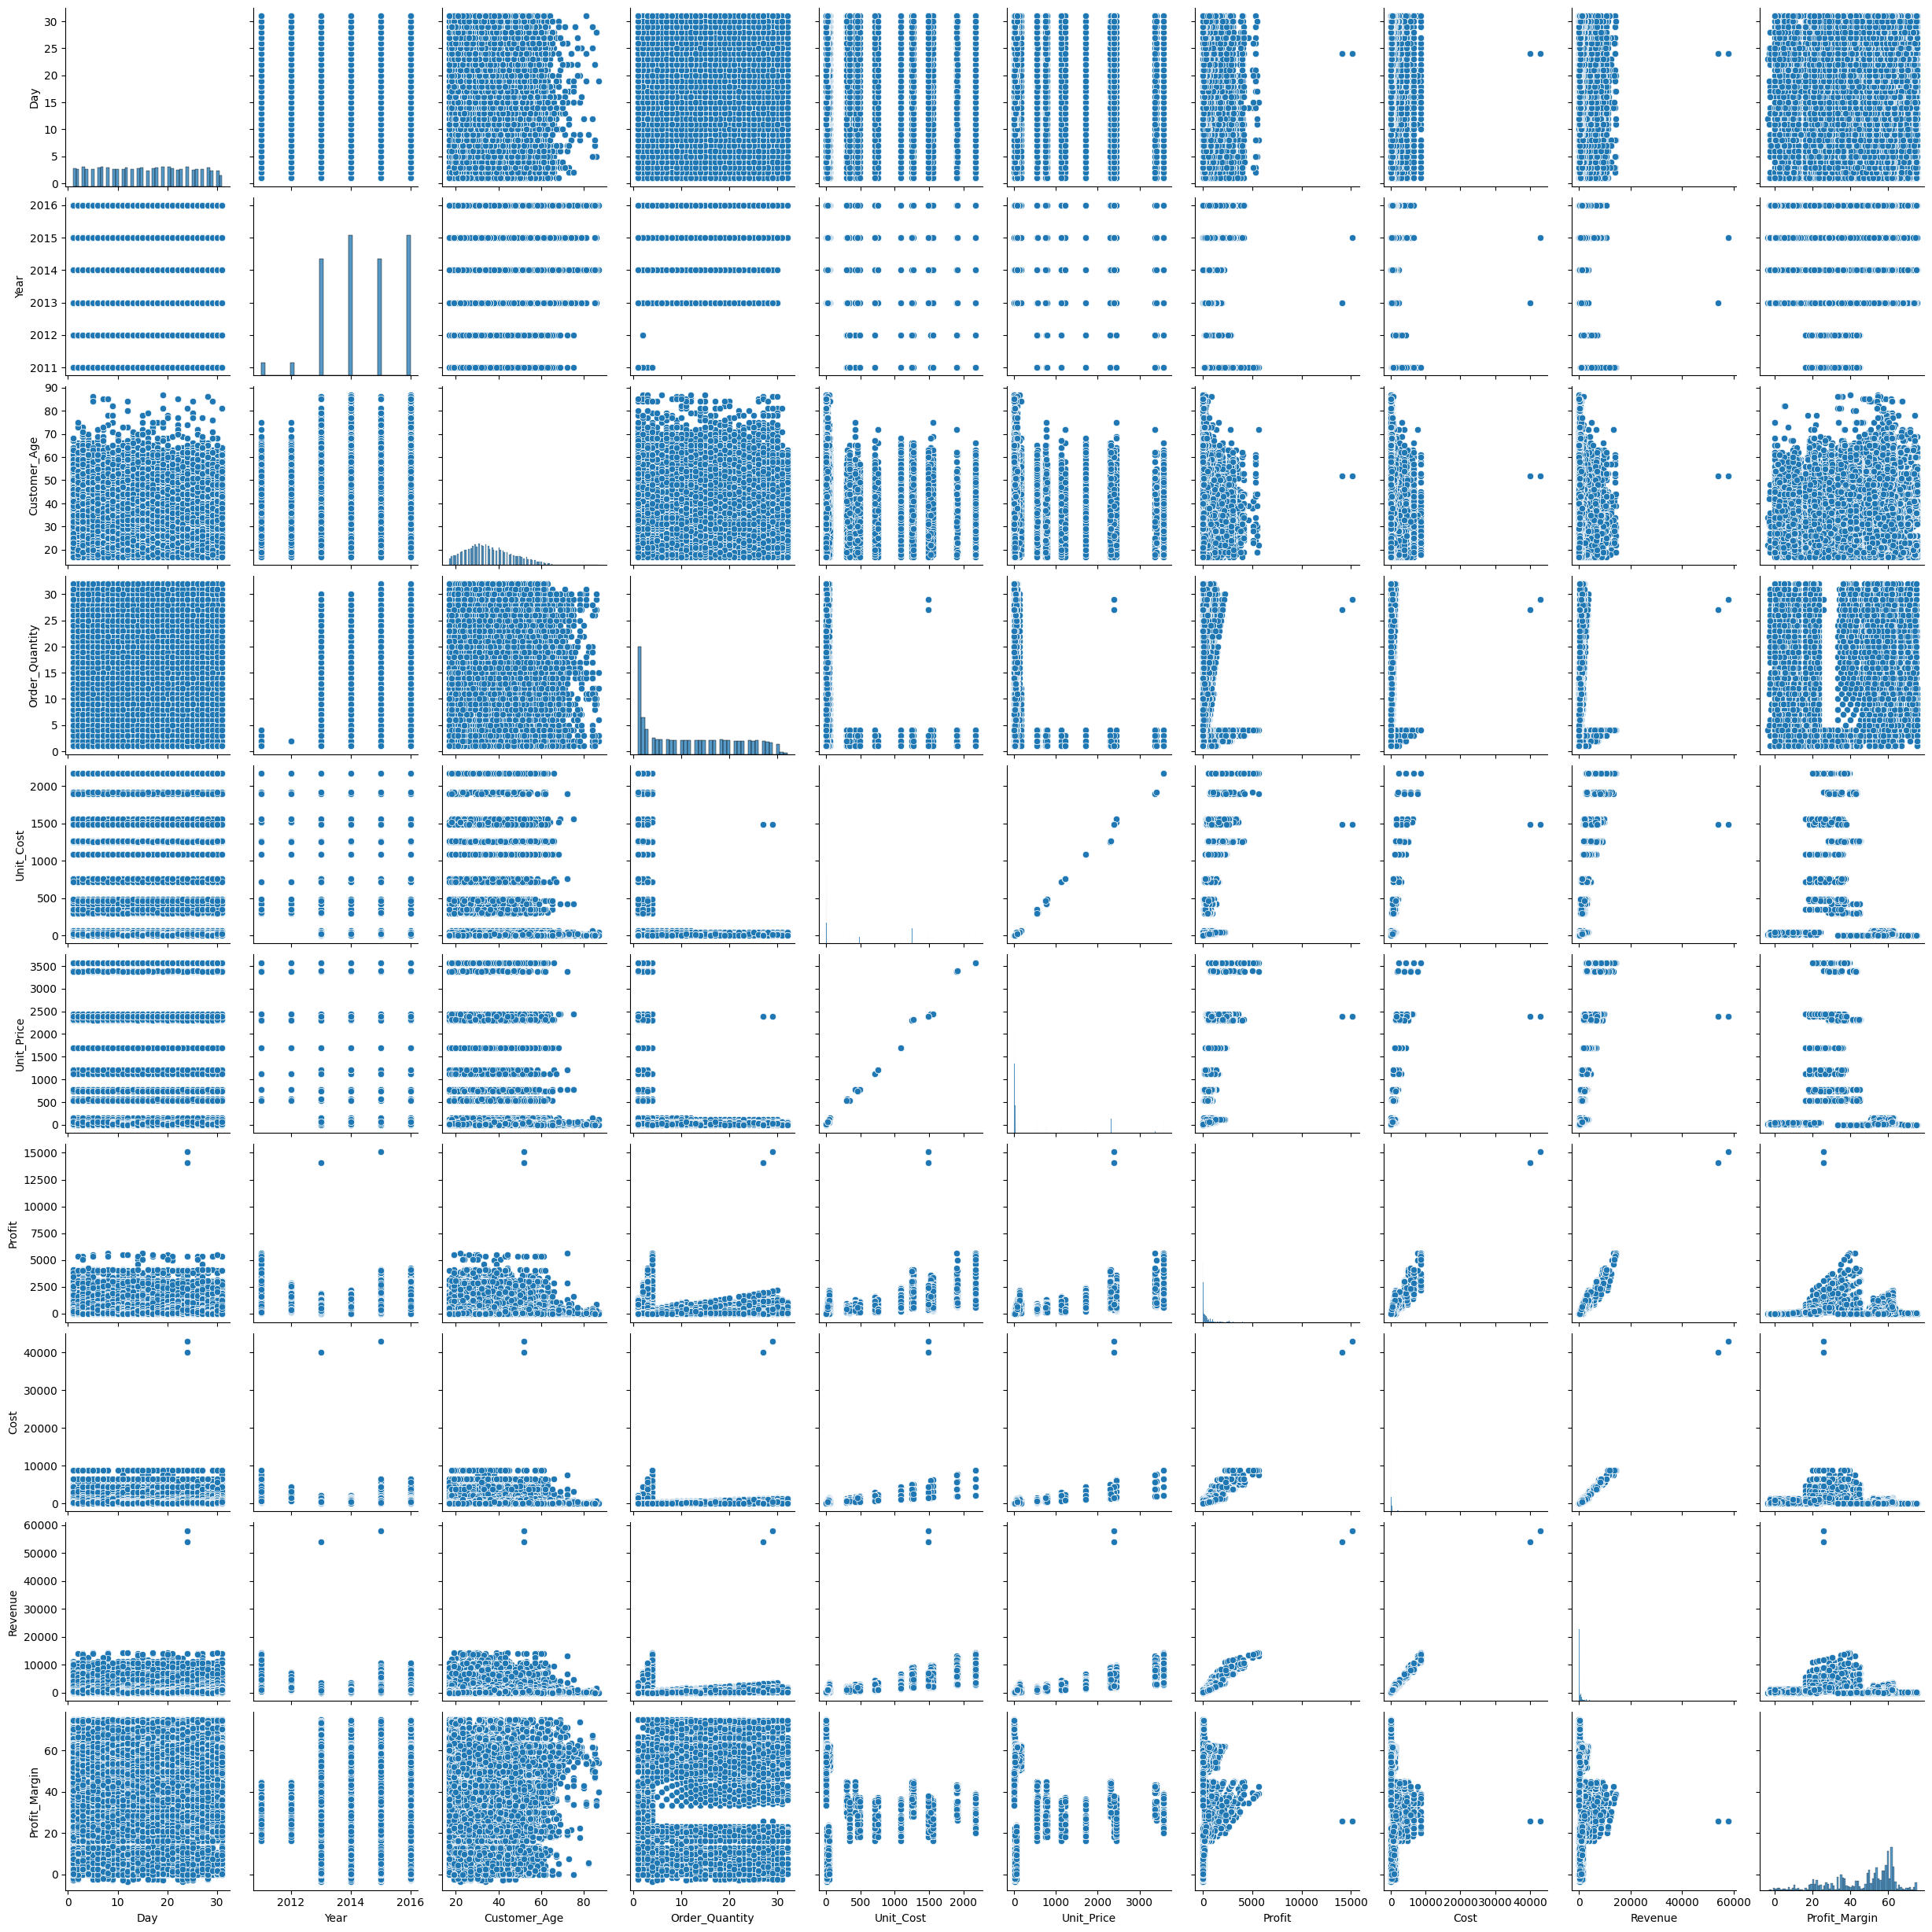

In [34]:
sns.pairplot(df)


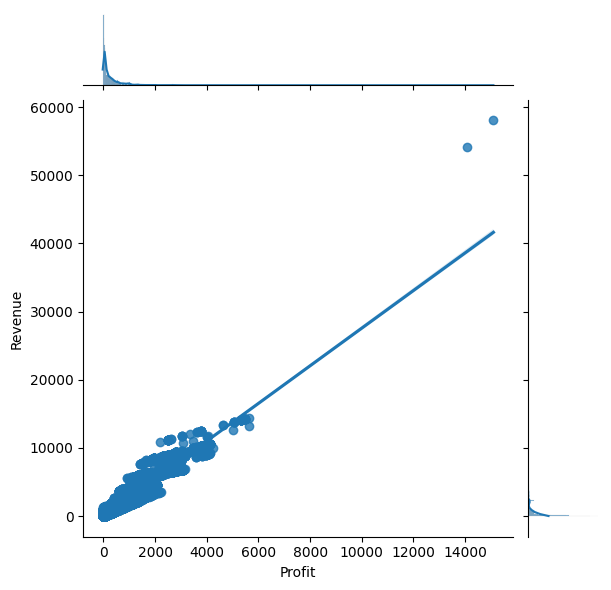

In [35]:
sns.jointplot(x='Profit',y='Revenue',data=df, kind='reg')


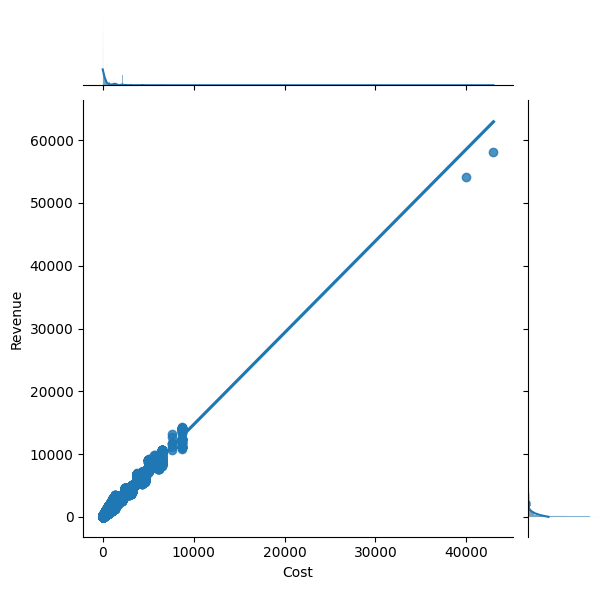

In [36]:
sns.jointplot(x='Cost',y='Revenue',data=df, kind='reg')


In [37]:
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().sum() > 0:
       df[col].fillna(df[col].median(), inplace=True)

In [38]:
for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().sum() > 0:
       df[col].fillna(df[col].mode()[0], inplace=True)

In [39]:
# Check categorical columns distribution
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nDistribution of {col}:")
    print(df[col].value_counts())
    print(f"Percentages:")
    print(df[col].value_counts(normalize=True) * 100)


Distribution of Calculated_Date:
Calculated_Date
2016-03-01    286
2014-03-01    284
2015-12-07    240
2013-12-07    240
2016-06-14    234
             ... 
2011-11-04      1
2012-11-04      1
2012-02-21      1
2012-05-29      1
2011-02-21      1
Name: count, Length: 1884, dtype: int64
Percentages:
Calculated_Date
2016-03-01    0.255275
2014-03-01    0.253490
2015-12-07    0.214217
2013-12-07    0.214217
2016-06-14    0.208861
                ...   
2011-11-04    0.000893
2012-11-04    0.000893
2012-02-21    0.000893
2012-05-29    0.000893
2011-02-21    0.000893
Name: proportion, Length: 1884, dtype: float64

Distribution of Month:
Month
June         11127
December     11109
May          11019
April        10090
March         9591
January       9192
February      8956
October       8678
November      8646
August        8128
September     8100
July          7400
Name: count, dtype: int64
Percentages:
Month
June         9.931629
December     9.915563
May          9.835232
April        9

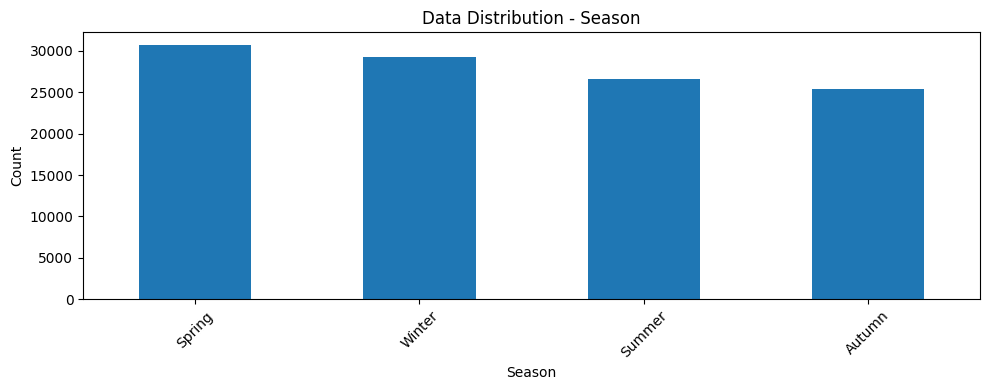

In [41]:
# Plot distribution
plt.figure(figsize=(10, 4))
df[col].value_counts().plot(kind='bar')
plt.title(f'Data Distribution - {col}')
plt.xlabel(col)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Day:
  - Number of outliers: 0 (0.00%)
  - Lower bound: -14.50
  - Upper bound: 45.50


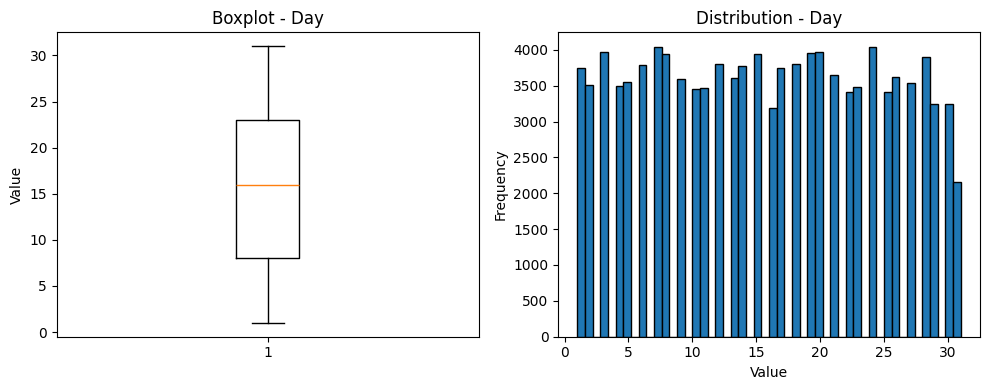


Year:
  - Number of outliers: 0 (0.00%)
  - Lower bound: 2008.50
  - Upper bound: 2020.50


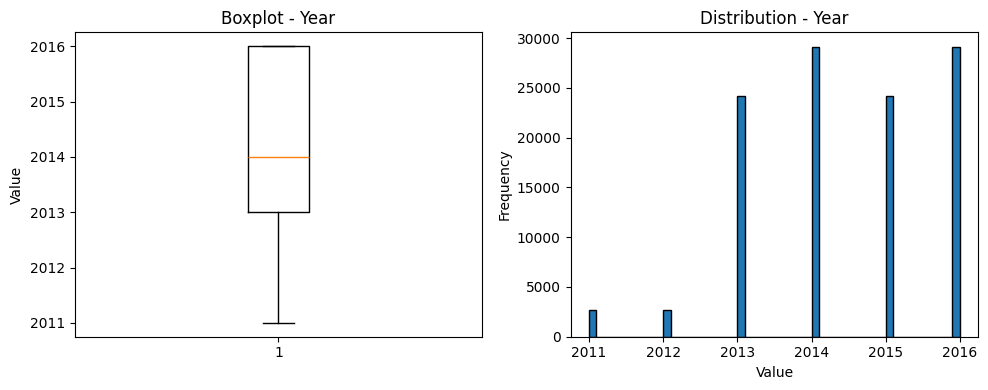


Customer_Age:
  - Number of outliers: 526 (0.47%)
  - Lower bound: 5.50
  - Upper bound: 65.50


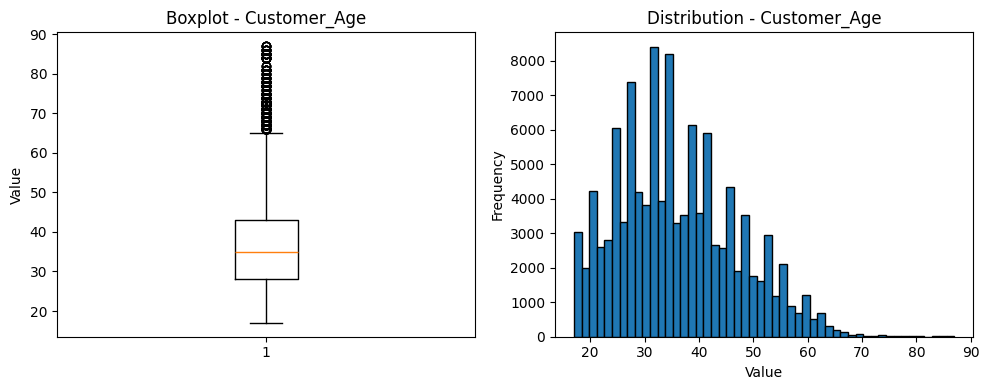


Order_Quantity:
  - Number of outliers: 0 (0.00%)
  - Lower bound: -25.00
  - Upper bound: 47.00


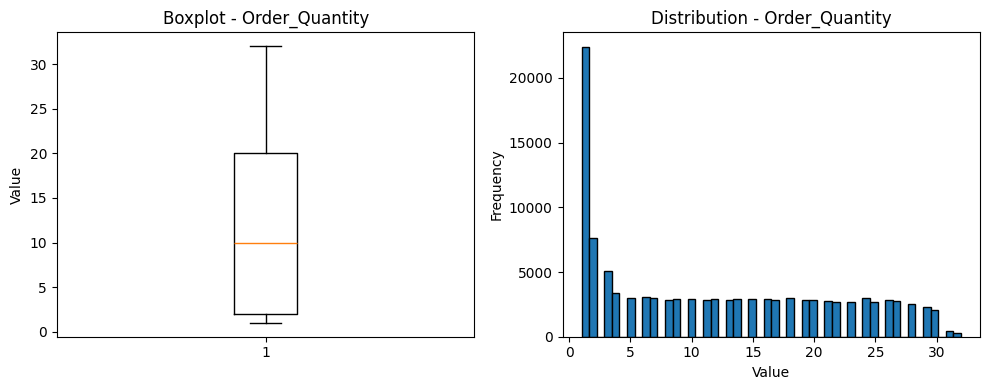


Unit_Cost:
  - Number of outliers: 25796 (23.02%)
  - Lower bound: -58.00
  - Upper bound: 102.00


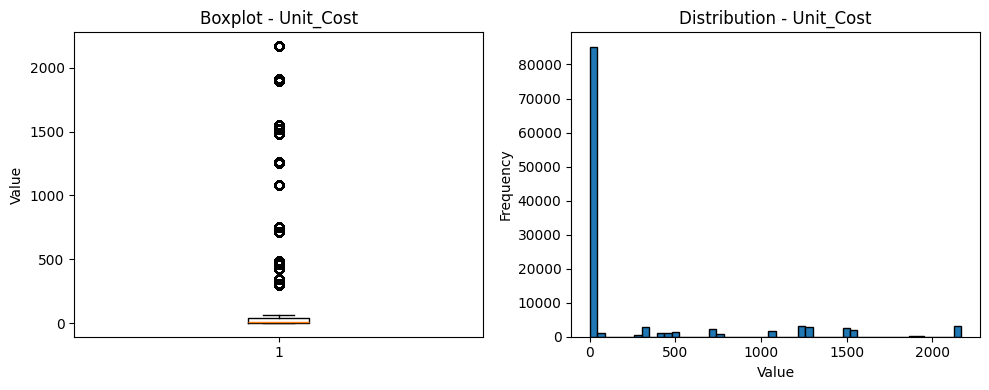


Unit_Price:
  - Number of outliers: 25796 (23.02%)
  - Lower bound: -92.50
  - Upper bound: 167.50


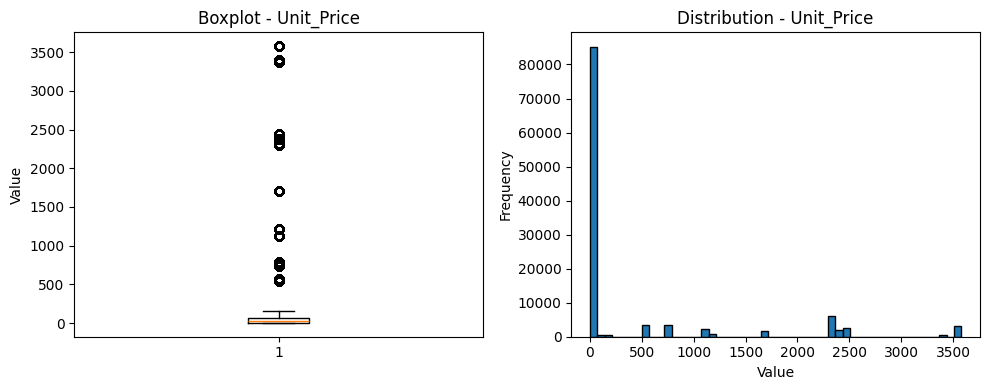


Profit:
  - Number of outliers: 9558 (8.53%)
  - Lower bound: -467.50
  - Upper bound: 856.50


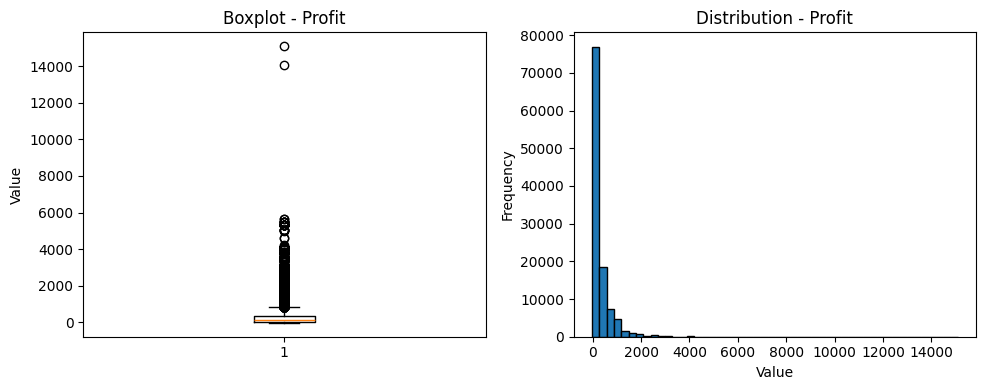


Cost:
  - Number of outliers: 17979 (16.05%)
  - Lower bound: -593.00
  - Upper bound: 1063.00


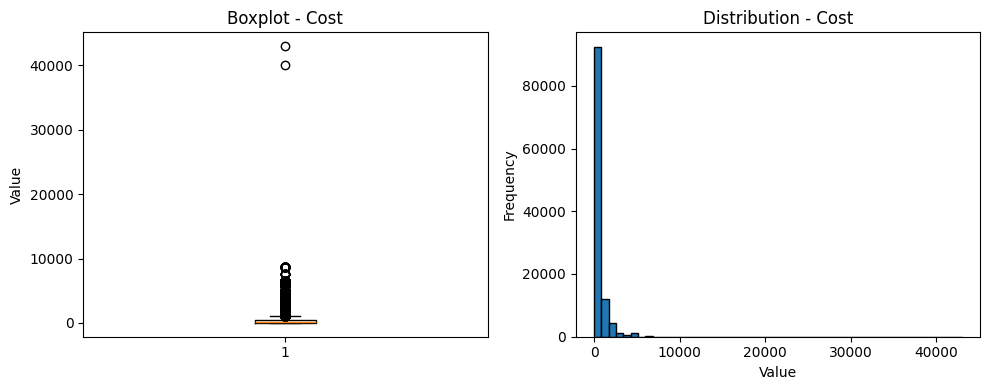


Revenue:
  - Number of outliers: 14603 (13.03%)
  - Lower bound: -1049.00
  - Upper bound: 1919.00


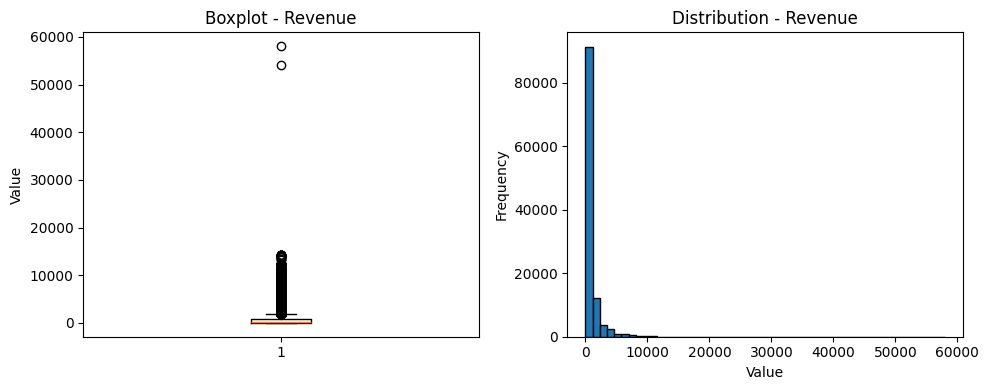


Profit_Margin:
  - Number of outliers: 58 (0.05%)
  - Lower bound: -0.25
  - Upper bound: 95.63


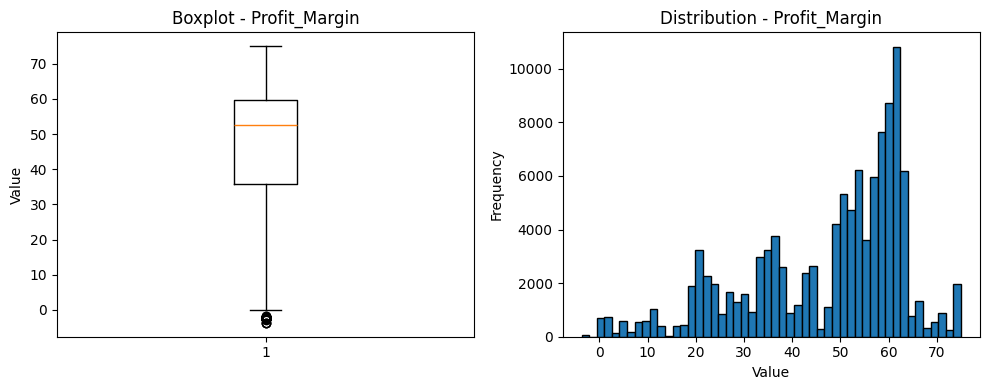

In [42]:
# Use IQR (Interquartile Range) method for outlier detection
numerical_cols = df.select_dtypes(include=[np.number]).columns

outliers_info = {}
for col in numerical_cols:
    # Calculate Q1 (first quartile) and Q3 (third quartile)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile range
    # Define bounds: any value outside 1.5 * IQR is considered an outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Count outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_count = len(outliers)
    outliers_percentage = (outliers_count / len(df)) * 100

    outliers_info[col] = {
        'count': outliers_count,
        'percentage': outliers_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

    print(f"\n{col}:")
    print(f"  - Number of outliers: {outliers_count} ({outliers_percentage:.2f}%)")
    print(f"  - Lower bound: {lower_bound:.2f}")
    print(f"  - Upper bound: {upper_bound:.2f}")

    # Plot Boxplot to visualize outliers
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.boxplot(df[col].dropna())
    plt.title(f'Boxplot - {col}')
    plt.ylabel('Value')

    plt.subplot(1, 2, 2)
    plt.hist(df[col].dropna(), bins=50, edgecolor='black')
    plt.title(f'Distribution - {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [44]:
# Convert date columns if present
date_columns = [col for col in df.columns if 'date' in col.lower()]
for col in date_columns:
    df[col] = pd.to_datetime(df[col])
    # Extract date features
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df[f'{col}_day'] = df[col].dt.day
    df[f'{col}_dayofweek'] = df[col].dt.dayofweek
    df[f'{col}_quarter'] = df[col].dt.quarter
    print(f"Extracted temporal features from {col}")
    # Drop original column
    df.drop(col, axis=1, inplace=True)

Extracted temporal features from Calculated_Date_year
Extracted temporal features from Calculated_Date_month
Extracted temporal features from Calculated_Date_day
Extracted temporal features from Calculated_Date_dayofweek
Extracted temporal features from Calculated_Date_quarter


In [50]:
# Label Encoding for categorical columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f" Converted {col} to numerical values")

In [51]:
target_column = None
for possible_name in ['Sales', 'Revenue', 'Unit_Price', 'Order_Quantity']:
    if possible_name in df.columns:
        target_column = possible_name
        break

if target_column is None:
    # If not found, use the last numerical column
    target_column = df.select_dtypes(include=[np.number]).columns[-1]
    print(f" Sales column not found, using {target_column}")

print(f"Target variable: {target_column}")

# Separate X and y
X = df.drop(target_column, axis=1)
y = df[target_column]


Target variable: Revenue


In [53]:
# Use SelectKBest with f_regression to select best features
# f_regression: measures linear relationship between each feature and target
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

print("\nFeature importance scores:")
print(feature_scores)


Feature importance scores:
                                Feature         Score
15                                 Cost  4.894511e+06
14                               Profit  1.204585e+06
13                           Unit_Price  2.268591e+05
12                            Unit_Cost  2.258020e+05
17                        Profit_Margin  1.390243e+04
11                       Order_Quantity  1.215761e+04
8                      Product_Category  1.128040e+04
2                                  Year  5.092452e+03
9                          Sub_Category  2.436517e+03
6                               Country  6.919277e+01
16                               Season  3.247712e+01
4                             Age_Group  1.997834e+01
3                          Customer_Age  9.696768e+00
5                       Customer_Gender  8.513862e+00
1                                 Month  7.379283e+00
10                              Product  4.983653e+00
0                                   Day  1.788435e+00


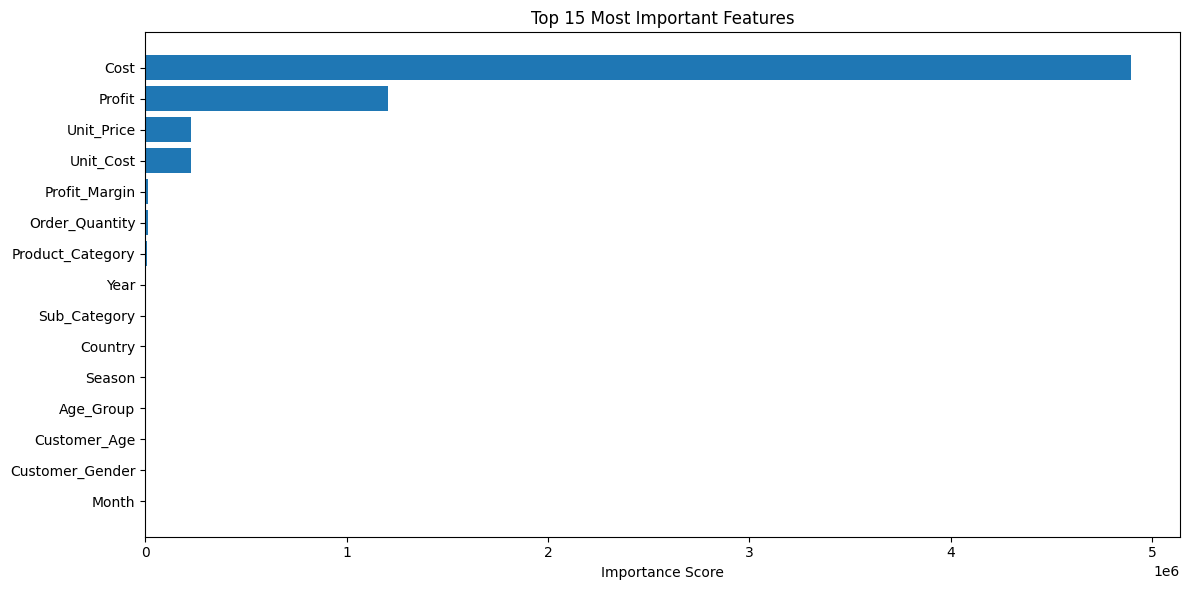

In [54]:
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_scores['Feature'][:15], feature_scores['Score'][:15])
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [56]:
# Select best features (take features with score above mean)
mean_score = feature_scores['Score'].mean()
selected_features = feature_scores[feature_scores['Score'] > mean_score]['Feature'].tolist()
print(f"\n Selected {len(selected_features)} features out of {len(X.columns)}")
print(f"Selected features: {selected_features}")

X_selected = X[selected_features]


 Selected 4 features out of 43
Selected features: ['Cost', 'Profit', 'Unit_Price', 'Unit_Cost']


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
mlflow.set_experiment("Bike_Sales_Forecasting_XGBoost")
print(" MLflow experiment created/selected")


2025/12/12 20:08:41 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/12 20:08:41 INFO mlflow.store.db.utils: Updating database tables
2025/12/12 20:08:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/12 20:08:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/12 20:08:42 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2025/12/12 20:08:42 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025/12/12 20:08:42 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025/12/12 20:08:42 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025/12/12 20:08:42 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025/12/12 20:08:42 INFO alembic.runtime.migration: Running 

 MLflow experiment created/selected


In [60]:
# Start MLflow run
with mlflow.start_run(run_name="baseline_model"):

    # Baseline model with default parameters
    base_model = XGBRegressor(
        random_state=42,
        n_estimators=100,  # number of trees
        learning_rate=0.1,  # learning rate
        max_depth=6,  # tree depth
        objective='reg:squarederror'  # loss function for regression
    )

    # Train model
    base_model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred_train = base_model.predict(X_train_scaled)
    y_pred_test = base_model.predict(X_test_scaled)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"\nBaseline model metrics:")
    print(f"  Train RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE: {train_mae:.4f}")
    print(f"  Test MAE: {test_mae:.4f}")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")

    # Log to MLflow
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 6)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("test_r2", test_r2)


Baseline model metrics:
  Train RMSE: 67.0752
  Test RMSE: 53.1312
  Train MAE: 8.8946
  Test MAE: 8.3131
  Train R²: 0.9974
  Test R²: 0.9983


In [62]:
# Define parameter grid for search
param_grid = {
    'n_estimators': [100, 200, 300],  # number of trees
    'max_depth': [3, 5, 7],  # tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # learning rate
    'subsample': [0.8, 1.0],  # sample ratio
    'colsample_bytree': [0.8, 1.0],  # feature ratio
    'min_child_weight': [1, 3, 5],  # minimum leaf weight
    'gamma': [0, 0.1, 0.2]  # minimum loss reduction for split
}
print("Search parameters:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

Search parameters:
  n_estimators: [100, 200, 300]
  max_depth: [3, 5, 7]
  learning_rate: [0.01, 0.1, 0.3]
  subsample: [0.8, 1.0]
  colsample_bytree: [0.8, 1.0]
  min_child_weight: [1, 3, 5]
  gamma: [0, 0.1, 0.2]


In [63]:
# TimeSeriesSplit: for time series data (better than regular K-Fold)
tscv = TimeSeriesSplit(n_splits=3)

In [65]:
# GridSearchCV: tries all possible combinations
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, objective='reg:squarederror'),
    param_grid=param_grid,
    cv=tscv,  # Cross-validation
    scoring='neg_mean_squared_error',  # metric to optimize
    verbose=1,  # print progress
    n_jobs=-1  # use all processors
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {-grid_search.best_score_:.4f}")

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV score: 5806.9113


2025/12/12 21:11:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Optimized model metrics:
  Train RMSE: 67.1409
  Test RMSE: 51.5448
  Train MAE: 5.4127
  Test MAE: 4.6871
  Train R²: 0.9974
  Test R²: 0.9984

 Improvement:
  RMSE: 2.99%
  MAE: 43.62%
  R²: 0.01%

 Feature importance in final model:
      feature  importance
0        Cost    0.873827
3   Unit_Cost    0.102614
1      Profit    0.014901
2  Unit_Price    0.008658


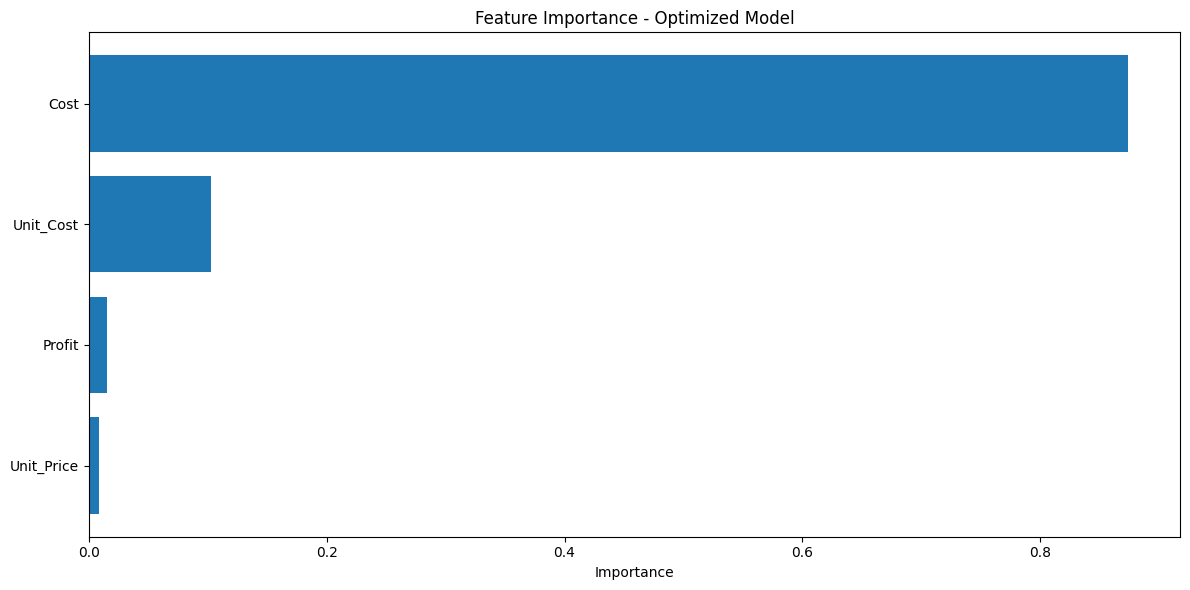

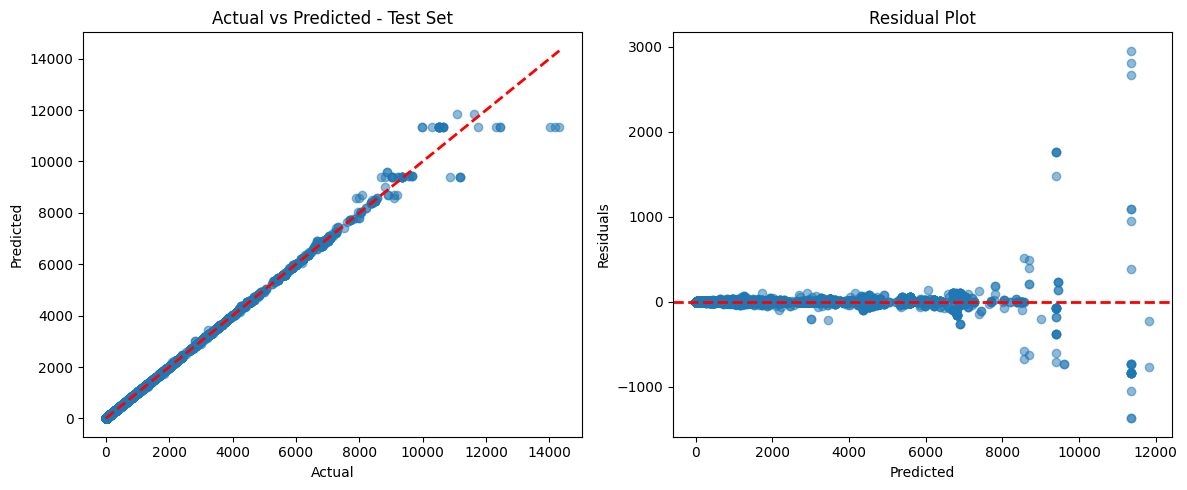

CV RMSE Scores: [89.60475277 80.66503064 57.26644994 65.8201377  69.65104848]
Mean CV RMSE: 72.6015 (+/- 22.6978)
 Model saved to: xgboost_bike_sales_model.json
 Scaler and Label Encoders saved

 Training Completed!

Final Model:
  - Number of features used: 4
  - Test RMSE: 51.5448
  - Test R²: 0.9984
  - Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}

 All experiments logged in MLflow
 To view results: mlflow ui


In [72]:
# Check if there's an active run and end it if necessary
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="optimized_model"):

    # Use best parameters
    best_model = grid_search.best_estimator_

    # Predictions
    y_pred_train_opt = best_model.predict(X_train_scaled)
    y_pred_test_opt = best_model.predict(X_test_scaled)

    # Calculate metrics
    train_rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_train_opt))
    test_rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_test_opt))
    train_mae_opt = mean_absolute_error(y_train, y_pred_train_opt)
    test_mae_opt = mean_absolute_error(y_test, y_pred_test_opt)
    train_r2_opt = r2_score(y_train, y_pred_train_opt)
    test_r2_opt = r2_score(y_test, y_pred_test_opt)

    print(f"\nOptimized model metrics:")
    print(f"  Train RMSE: {train_rmse_opt:.4f}")
    print(f"  Test RMSE: {test_rmse_opt:.4f}")
    print(f"  Train MAE: {train_mae_opt:.4f}")
    print(f"  Test MAE: {test_mae_opt:.4f}")
    print(f"  Train R²: {train_r2_opt:.4f}")
    print(f"  Test R²: {test_r2_opt:.4f}")

    # Compare with baseline model
    print(f"\n Improvement:")
    print(f"  RMSE: {((test_rmse - test_rmse_opt) / test_rmse * 100):.2f}%")
    print(f"  MAE: {((test_mae - test_mae_opt) / test_mae * 100):.2f}%")
    print(f"  R²: {((test_r2_opt - test_r2) / test_r2 * 100):.2f}%")

    # Log parameters and metrics to MLflow
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("train_rmse", train_rmse_opt)
    mlflow.log_metric("test_rmse", test_rmse_opt)
    mlflow.log_metric("train_mae", train_mae_opt)
    mlflow.log_metric("test_mae", test_mae_opt)
    mlflow.log_metric("train_r2", train_r2_opt)
    mlflow.log_metric("test_r2", test_r2_opt)

    # Log model
    mlflow.xgboost.log_model(best_model, "model")

    # Save Feature Importance
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n Feature importance in final model:")
    print(feature_importance)

    # Plot Feature Importance
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
    plt.xlabel('Importance')
    plt.title('Feature Importance - Optimized Model')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    mlflow.log_artifact('feature_importance.png')
    plt.show()

    # Plot Actual vs Predicted
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_test_opt, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted - Test Set')

    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred_test_opt
    plt.scatter(y_pred_test_opt, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    plt.tight_layout()
    plt.savefig('predictions_plot.png')
    mlflow.log_artifact('predictions_plot.png')
    plt.show()


cv_scores = cross_val_score(
    best_model, X_train_scaled, y_train,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error'
)

cv_rmse_scores = np.sqrt(-cv_scores)
print(f"CV RMSE Scores: {cv_rmse_scores}")
print(f"Mean CV RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std() * 2:.4f})")



# Save model locally
best_model.save_model('xgboost_bike_sales_model.json')
print(" Model saved to: xgboost_bike_sales_model.json")

# Save Scaler and Label Encoders
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print(" Scaler and Label Encoders saved")

# ==================== Final Summary ====================
print("\n" + "="*50)
print(" Training Completed!")
print("="*50)
print(f"\nFinal Model:")
print(f"  - Number of features used: {len(selected_features)}")
print(f"  - Test RMSE: {test_rmse_opt:.4f}")
print(f"  - Test R²: {test_r2_opt:.4f}")
print(f"  - Best parameters: {grid_search.best_params_}")
print(f"\n All experiments logged in MLflow")
print(f" To view results: mlflow ui")